In [1]:
import argparse
import copy
import os
import sys
import time

import numpy as np
import pandas as pd
from pandas.core.arrays import boolean
import torch
from scipy import stats
from sklearn import preprocessing
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import models
import utils as ut
from models import AEBase, Predictor, PretrainedPredictor
from sklearn.metrics.cluster import adjusted_rand_score


import scanpypip.preprocessing as pp
import scanpypip.utils as scut 

import scanpy as sc

In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in M

In [2]:
class Arguments:
    def __init__(self):   
        self.epochs = 500
        self.bottleneck = 512
        self.missing_value = np.nan
        self.target_data = "data/GSE108394/GSM2897334/"
        self.source_data = "data/GDSC2_expression.csv"
        self.test_size = 0.2
        self.valid_size = 0.2
        self.source_model_path = "saved/models/pretrained_novar.pkl"
        self.target_model_path = "saved/models/"
        self.logging_file = "saved/logs/"
        self.batch_size = 200
        self.source_h_dims = "2048,1024"
        self.target_h_dims = "512,256"

        self.var_genes_disp = 0
        self.pretrain_path = "saved/models/pretrained_novar.pkl"
        self.min_n_genes = 0
        self.max_n_genes = 20000
        self.min_g = 200
        self.min_c = 3

        
args = Arguments()

In [3]:
epochs = args.epochs
dim_au_out = args.bottleneck #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1
na = args.missing_value
data_path = args.target_data
test_size = args.test_size
valid_size = args.valid_size
g_disperson = args.var_genes_disp
min_n_genes = args.min_n_genes
max_n_genes = args.max_n_genes
source_model_path = args.source_model_path
target_model_path = args.target_model_path 
pretrain_path = args.pretrain_path
log_path = args.logging_file
batch_size = args.batch_size
encoder_hdims = args.source_h_dims.split(",")
encoder_hdims = list(map(int, encoder_hdims))
source_data_path = args.source_data 


In [4]:
now=time.strftime("%Y-%m-%d-%H-%M-%S")
log_path = log_path+now+".txt"
export_name = data_path.replace("/","")
pretrain_path = "saved/models/ae_"+export_name+now+".pkl"

In [5]:
#scv = pd.read_csv('data/GSE117872/GSE117872_good_Data_TPM.txt',sep="\t")

In [6]:
#scv.shape

In [7]:
adata = sc.read_h5ad('saved/resultsdataGSE108394GSM2897334.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 1302 × 7714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden'
    var: 'n_cells', 'mt', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_AE', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
annotation = pd.read_csv('data/GSE117872/GSE117872_good_Data_cellinfo.txt',sep="\t")

In [10]:
annotation

,groups,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8
0,RHC6558,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
1,RHC6559,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
2,RHC6560,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
3,RHC6561,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
4,RHC6562,HN148M,bisque,HN148,Metastatic,Sensitive,3,1,1
...,...,...,...,...,...,...,...,...,...
1297,RHH3298,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1298,RHH3299,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1299,RHH3300,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3
1300,RHH3301,HN137PCRDH,brown,HN137,Primary,Holiday,2,2,3


In [11]:
for item in annotation.columns:
    #print(annotation.loc[:,item])
    #if(annotation.loc[:,item].dtype == object):
    adata.obs[str(item)] = annotation.loc[:,item].convert_dtypes('str').values
    #else:
        #adata.obs[str(item)] = annotation.loc[:,item].values

D:\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)
D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'cell_color' as categorical
... storing 'patient_id' as categorical
... storing 'origin' as categorical
... storing 'drug_status' as categorical
... storing 'cluster' as categorical


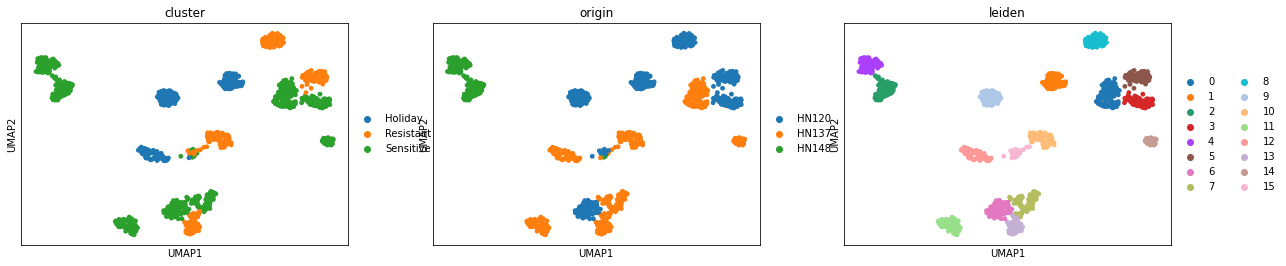

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.5)
sc.pl.umap(adata,color=["cluster","origin","leiden"])

D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


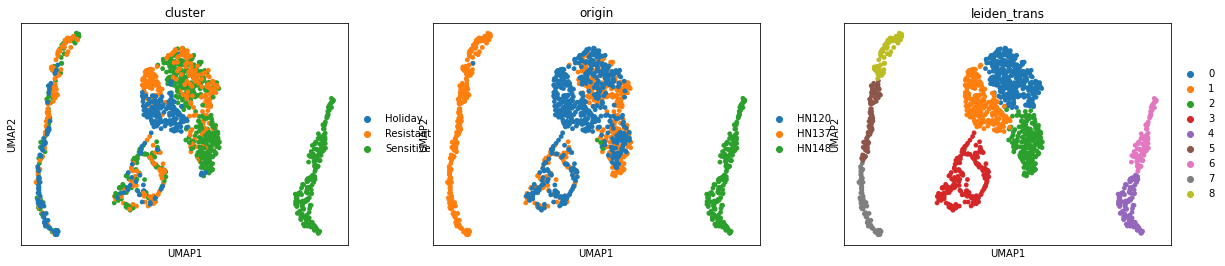

In [13]:
sc.pp.neighbors(adata,use_rep='X_AE',key_added="Trans")
sc.tl.umap(adata,neighbors_key="Trans")
sc.tl.leiden(adata,neighbors_key="Trans",key_added="leiden_trans",resolution=0.5)
sc.pl.umap(adata,color=["cluster","origin","leiden_trans"],neighbors_key="Trans")

In [14]:
adjusted_rand_score(adata.obs["leiden"], adata.obs["cluster"])

0.1909483157623906

In [15]:
adjusted_rand_score(adata.obs["leiden_trans"], adata.obs["cluster"])

0.11160602592919541

In [16]:
adjusted_rand_score(adata.obs["leiden_trans"], adata.obs["leiden"])

0.316750296317601

In [17]:
adata

AnnData object with n_obs × n_vars = 1302 × 7714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'groups', 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'leiden_trans'
    var: 'n_cells', 'mt', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cluster_colors', 'origin_colors', 'Trans', 'leiden_trans_colors'
    obsm: 'X_AE', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'Trans_distances', 'Trans_connectivities'